<a href="https://colab.research.google.com/github/ZachGermain/Asteroid_Clustering/blob/master/Code/Asteroid_Clustering_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pylab as pl
import numpy as np
import sklearn as skl
from sklearn import preprocessing #sklearn does not automatically import subpackages
from sklearn import manifold
from sklearn import cluster

# **Data Opening and Preprocessing**

In [2]:
#astDf = pd.read_csv("https://raw.githubusercontent.com/ZachGermain/Asteroid_Clustering/master/Data/asteroidsBelt.csv") #Whole belt by JPL
astDf = pd.read_csv("https://raw.githubusercontent.com/ZachGermain/Asteroid_Clustering/master/Data/asteroidsMainBelt.csv") #Main belt by JPL
astDf = astDf.set_index('id')
astDf.head()

,spec_B,e,a,i
id,,,,
a0000001,C,0.076009,2.769165,10.594067
a0000002,B,0.230337,2.772466,34.836234
a0000003,Sk,0.256942,2.669150,12.988919
a0000004,V,0.088721,2.361418,7.141771
a0000005,S,0.191095,2.574249,5.366988


In [3]:
astDf.shape

(1212, 4)

In [4]:
astDf.describe()

,e,a,i
count,1212.000000,1212.000000,1212.000000
mean,0.143217,2.654361,8.519452
std,0.070464,0.262556,5.724792
min,0.004735,2.125690,0.264810
25%,0.086395,2.415790,4.608699
50%,0.140735,2.724440,7.270116
75%,0.190543,2.791325,10.786604
max,0.380217,3.197464,35.852723


In [5]:
np.unique(astDf.spec_B)

array(['A', 'B', 'C', 'Cb', 'Cg', 'Cgh', 'Ch', 'D', 'K', 'L', 'Ld', 'O',
       'R', 'S', 'Sa', 'Sk', 'Sl', 'Sq', 'Sr', 'T', 'V', 'X', 'Xc', 'Xe',
       'Xk'], dtype=object)

In [6]:
for i in np.unique(astDf.spec_B):
  print("{0}: {1}".format(i, list(astDf.spec_B).count(i)))

A: 9
B: 55
C: 137
Cb: 27
Cg: 8
Cgh: 15
Ch: 133
D: 6
K: 31
L: 32
Ld: 11
O: 1
R: 4
S: 346
Sa: 29
Sk: 12
Sl: 45
Sq: 44
Sr: 11
T: 10
V: 35
X: 102
Xc: 54
Xe: 20
Xk: 35


## **Data Reduction**

Some data preprocessing: 
  Replacing transitional types with original types.
    Lets similar types be grouped together.
  Getting rid of types with a small number of the asteroids of the S-type as these are closer to outliers than clusters.

In [7]:

cTransitions = [ 'Cb', 'Cg', 'Cgh', 'Ch' ]
sTransitions = [ 'Sa', 'Sk', 'Sl', 'Sq', 'Sr' ]
xTransitions  = [ 'Xc', 'Xe', 'Xk' ]
lTransitions = [ 'Ld' ]

for c in cTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(c, 'C')

for s in sTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(s, 'S')

for x in xTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(x, 'X')

for l in lTransitions:
  astDf["spec_B"] = astDf["spec_B"].str.replace(l, 'L')

np.unique(astDf.spec_B)


array(['A', 'B', 'C', 'D', 'K', 'L', 'O', 'R', 'S', 'T', 'V', 'X'],
      dtype=object)

In [8]:

tinyTypes = [ 'A', 'D', 'O', 'R', 'T', 'U' ] #Cutoff of 20 and transition state reduced
#tinyTypes = [ 'A', 'Cg', 'Cgh', 'D', 'Ld', 'O', 'R', 'Sk', 'Sr', 'T', 'U' ] #Cutoff of 20 and not reduced
#tinyTypes = [ 'A', 'Cb', 'Cg', 'Cgh', 'D', 'K', 'L', 'Ld', 'O', 'R', 'Sa',
#             'Sk', 'Sl', 'Sq', 'Sr', 'T', 'U', 'V', 'Xe', 'Xk' ] #Cutoff of 50 and not reduced

for t in tinyTypes:
  astDf = astDf[ astDf["spec_B"] != t ]

np.unique(astDf.spec_B)


array(['B', 'C', 'K', 'L', 'S', 'V', 'X'], dtype=object)

In [9]:
for i in np.unique(astDf.spec_B):
  print("{0}: {1}".format(i, list(astDf.spec_B).count(i)))

B: 55
C: 320
K: 31
L: 43
S: 487
V: 35
X: 211


In [10]:
astDf.head()

,spec_B,e,a,i
id,,,,
a0000001,C,0.076009,2.769165,10.594067
a0000002,B,0.230337,2.772466,34.836234
a0000003,S,0.256942,2.669150,12.988919
a0000004,V,0.088721,2.361418,7.141771
a0000005,S,0.191095,2.574249,5.366988


In [11]:
astDf.describe()

,e,a,i
count,1182.000000,1182.000000,1182.000000
mean,0.143680,2.652084,8.510233
std,0.070622,0.263288,5.729076
min,0.004735,2.125690,0.264810
25%,0.086475,2.411559,4.599843
50%,0.141162,2.722164,7.288570
75%,0.191027,2.790944,10.744221
max,0.380217,3.197464,35.852723


The reduction does not seem to have a significant effect on the data distribution.

## **Separate Data into Orbital Parameters and Taxonomy**

In [12]:
taxonomy = astDf[['spec_B']]
taxonomy.head()

,spec_B
id,
a0000001,C
a0000002,B
a0000003,S
a0000004,V
a0000005,S


In [13]:
astDf = astDf.drop(labels = 'spec_B', axis = 1)
astDf.head()

,e,a,i
id,,,
a0000001,0.076009,2.769165,10.594067
a0000002,0.230337,2.772466,34.836234
a0000003,0.256942,2.669150,12.988919
a0000004,0.088721,2.361418,7.141771
a0000005,0.191095,2.574249,5.366988


## **Scaling Data**

In [14]:
astScaled = preprocessing.scale(astDf)
astScaled.mean(0).round(2), astScaled.std(0)

(array([-0., -0.,  0.]), array([1., 1., 1.]))

# **Data Visualization**

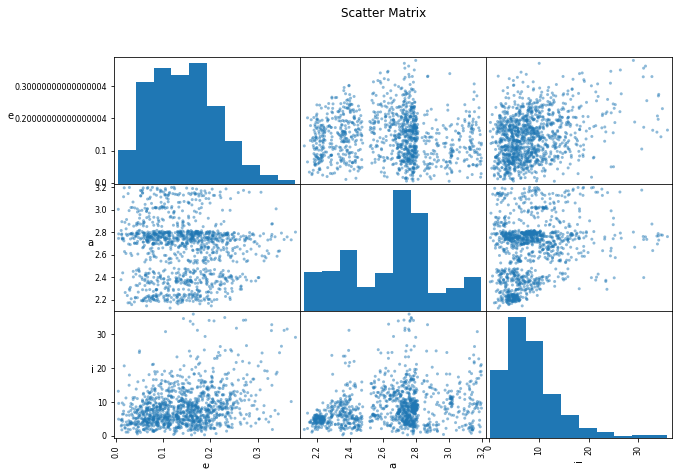

In [15]:
axs = pd.plotting.scatter_matrix(astDf, figsize=(10,7));
for x in range(len(axs)):
    for y in range(len(axs)):
        if x == len(axs) - 1:
            #to make x axis name vertical  
            axs[x, y].xaxis.label.set_rotation(90);
        if y == 0:    
            axs[x, y].yaxis.label.set_rotation(0);
pl.suptitle("Scatter Matrix");

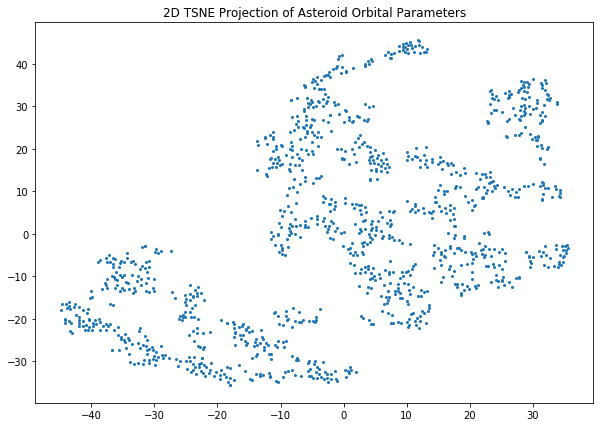

In [16]:
twodproj = manifold.TSNE(random_state = 7).fit_transform(astScaled)
pl.figure(figsize = (10,7))
pl.scatter(twodproj[:,0], twodproj[:,1], s = 4)
pl.title("2D TSNE Projection of Asteroid Orbital Parameters");

# **Clustering**

## **Finding Cluster Centers**

In [17]:
numClusters = len(np.unique(taxonomy.spec_B))
numClusters

7

In [18]:
clusterCenter = np.zeros((numClusters, 3))
clusterTaxonLabels = np.unique(taxonomy.spec_B)

for taxon, clustNum in zip(clusterTaxonLabels, range(0, numClusters)):
  indices = np.flatnonzero(taxonomy['spec_B'] == taxon)
  a = astScaled[indices, 0]
  e = astScaled[indices, 1]
  i = astScaled[indices, 2]
  clusterCenter[clustNum, 0] = a.mean()
  clusterCenter[clustNum, 1] = e.mean()
  clusterCenter[clustNum, 2] = i.mean()

clusterCenter, clusterTaxonLabels

(array([[ 0.42809721,  0.33206811,  0.47236963],
        [ 0.16286799,  0.40348023,  0.10550881],
        [-0.24238922,  0.74614686,  0.21441976],
        [-0.24004784,  0.15495958,  0.01103664],
        [-0.05203711, -0.40649021, -0.18821732],
        [-0.55721543, -1.08224603, -0.43899704],
        [-0.0615278 ,  0.27804792,  0.19034119]]),
 array(['B', 'C', 'K', 'L', 'S', 'V', 'X'], dtype=object))

Interestingly enough, one can see significant differences of the means between clusters

## **K-Means Clustering Using One Iteration of Centers**

In [19]:
clusteredAst = cluster.KMeans(n_clusters=numClusters, init = clusterCenter).fit(astScaled)

/usr/local/lib/python3.6/dist-packages/sklearn/cluster/k_means_.py:972: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  return_n_iter=True)


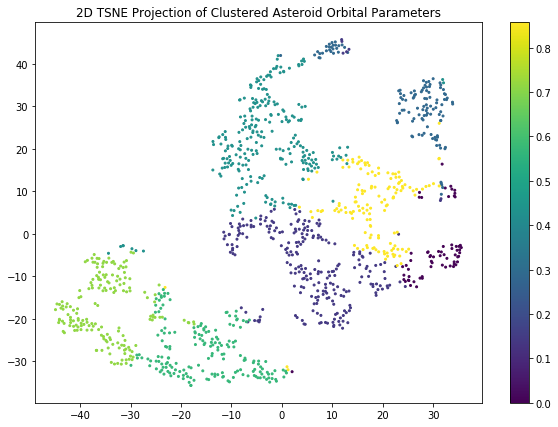

In [20]:
twodproj = manifold.TSNE(random_state = 7).fit_transform(astScaled)
pl.figure(figsize = (10,7))
pl.scatter(twodproj[:,0], twodproj[:,1], c = clusteredAst.labels_/clusteredAst.n_clusters,
           s = 4)
pl.colorbar()
pl.title("2D TSNE Projection of Clustered Asteroid Orbital Parameters");

In [21]:
clusterTaxonCts = np.zeros((numClusters, numClusters))
clusterCts = np.zeros(numClusters)

for clustNum in np.unique(clusteredAst.labels_):
  clusterIndices = np.flatnonzero(clusteredAst.labels_ == clustNum)
  taxons = taxonomy.spec_B[ clusterIndices ]
  clusterCts[clustNum] = taxons.count()
  for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
    clusterTaxonCts[clustNum][taxonNum]  = taxons[ taxons == taxon ].count()

print("Order of Taxons:\n", np.unique(taxonomy.spec_B))
print("Taxon Counts per Cluster:\n", clusterTaxonCts)
print("Counts per Cluster:\n", clusterCts)

Order of Taxons:
 ['B' 'C' 'K' 'L' 'S' 'V' 'X']
Taxon Counts per Cluster:
 [[ 11.  19.   2.   1.  14.   0.  17.]
 [ 10. 100.   4.   4.  84.   0.  45.]
 [ 11.  49.  16.   4.  13.   0.  30.]
 [  5.  66.   6.  17. 110.   0.  48.]
 [ 11.  31.   0.   6. 112.   8.  13.]
 [  4.  12.   0.   3. 104.  27.  24.]
 [  3.  43.   3.   8.  50.   0.  34.]]
Counts per Cluster:
 [ 64. 247. 123. 252. 181. 174. 141.]


## **K-Means Clustering using n-Iterations**

Order of Taxons:
 ['B' 'C' 'K' 'L' 'S' 'V' 'X']
Taxon Counts per Cluster:
 [[  3.  13.   0.   3. 100.  26.  24.]
 [  3.  50.  15.   8.  42.   0.  48.]
 [  6.  68.   5.   7.  55.   0.  35.]
 [  6.  62.   8.  16.  94.   0.  43.]
 [ 12.  27.   1.   4. 116.   9.  13.]
 [ 15.  87.   1.   5.  67.   0.  38.]
 [ 10.  13.   1.   0.  13.   0.  10.]]
Counts per Cluster:
 [169. 166. 176. 229. 182. 213.  47.]


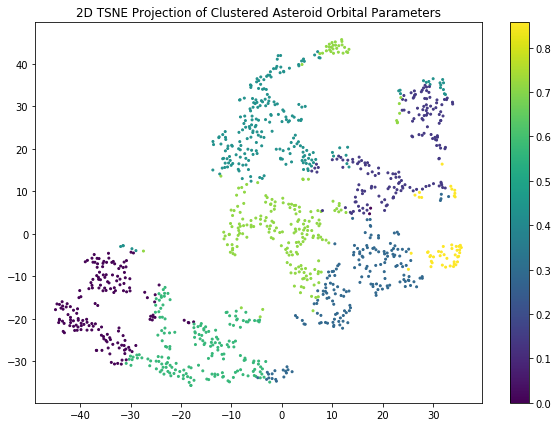

In [22]:
nIter = 10; #1000 iterations has similar numerical results 

clusteredAst2 = cluster.KMeans(n_clusters=numClusters, n_init = nIter, random_state = 17).fit(astScaled)

twodproj2 = manifold.TSNE(random_state = 7).fit_transform(astScaled)
pl.figure(figsize = (10,7))
pl.scatter(twodproj[:,0], twodproj[:,1], c = clusteredAst2.labels_/clusteredAst2.n_clusters,
           s = 4)
pl.colorbar()
pl.title("2D TSNE Projection of Clustered Asteroid Orbital Parameters");

clusterTaxonCts2 = np.zeros((numClusters, numClusters))
clusterCts2 = np.zeros(numClusters)

for clustNum in np.unique(clusteredAst2.labels_):
  clusterIndices2 = np.flatnonzero(clusteredAst2.labels_ == clustNum)
  taxons2 = taxonomy.spec_B[ clusterIndices2 ]
  clusterCts2[clustNum] = taxons2.count()
  for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
    clusterTaxonCts2[clustNum][taxonNum]  = taxons2[ taxons2 == taxon ].count()

print("Order of Taxons:\n", np.unique(taxonomy.spec_B))
print("Taxon Counts per Cluster:\n", clusterTaxonCts2)
print("Counts per Cluster:\n", clusterCts2)

# **Cluster Analysis**

Using clustering based on center points

## **Purity Per Cluster**

In [23]:
totPurityArr = np.zeros(numClusters)
for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
  totPurityArr[taxonNum] = (taxonomy.spec_B[taxonomy.spec_B == taxon]).count()/taxonomy.spec_B.count()

for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
  print("{0}: {1:.3f}".format(np.unique(taxonomy.spec_B)[taxonNum], totPurityArr[taxonNum]))

B: 0.047
C: 0.271
K: 0.026
L: 0.036
S: 0.412
V: 0.030
X: 0.179


In [24]:
purityArr = np.zeros((numClusters, numClusters))
for clusterNum in range(0, numClusters):
  print("For Cluster {0}:".format(clusterNum + 1))
  for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
    purityArr[clusterNum][taxonNum] = (clusterTaxonCts[clusterNum][taxonNum])/clusterCts[clusterNum]
    print("{0}: {1:.3f}".format(taxon, purityArr[clusterNum][taxonNum]))
  print("")

For Cluster 1:
B: 0.172
C: 0.297
K: 0.031
L: 0.016
S: 0.219
V: 0.000
X: 0.266

For Cluster 2:
B: 0.040
C: 0.405
K: 0.016
L: 0.016
S: 0.340
V: 0.000
X: 0.182

For Cluster 3:
B: 0.089
C: 0.398
K: 0.130
L: 0.033
S: 0.106
V: 0.000
X: 0.244

For Cluster 4:
B: 0.020
C: 0.262
K: 0.024
L: 0.067
S: 0.437
V: 0.000
X: 0.190

For Cluster 5:
B: 0.061
C: 0.171
K: 0.000
L: 0.033
S: 0.619
V: 0.044
X: 0.072

For Cluster 6:
B: 0.023
C: 0.069
K: 0.000
L: 0.017
S: 0.598
V: 0.155
X: 0.138

For Cluster 7:
B: 0.021
C: 0.305
K: 0.021
L: 0.057
S: 0.355
V: 0.000
X: 0.241



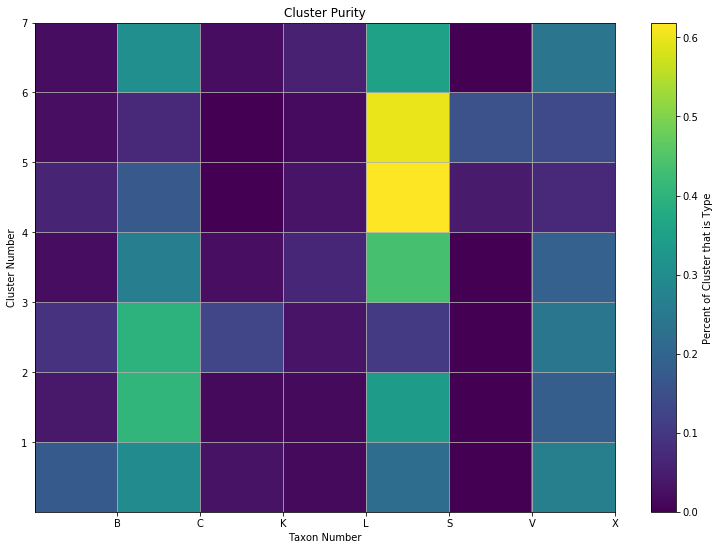

In [25]:
ax = pl.figure(figsize = (13, 9))
pl.pcolor(purityArr, vmin = 0, vmax = np.max(purityArr))
pl.title("Cluster Purity")
pl.colorbar(label = "Percent of Cluster that is Type")
pl.xlabel("Taxon Number")
pl.xticks(np.arange(1, numClusters + 1), labels = np.unique(taxonomy.spec_B))
pl.ylabel("Cluster Number")
pl.yticks(np.arange(1, numClusters + 1))
pl.grid();

In [26]:
for i in range(0, numClusters):
  sumNum = 0
  for j in range(0, numClusters):
    sumNum+=purityArr[i,j];
  print("{0:.2f}".format(sumNum))

1.00
1.00
1.00
1.00
1.00
1.00
1.00


## **Distribution of Taxonomic Types**

In [27]:
taxonArr = np.zeros((numClusters, numClusters))
for taxon, taxonNum in zip(np.unique(taxonomy.spec_B), range(0, numClusters)):
  print("For {0}:".format(taxon))
  for clusterNum in range(0, numClusters):
    taxonArr[taxonNum][clusterNum] = (clusterTaxonCts[clusterNum][taxonNum])/taxonomy.spec_B[taxonomy.spec_B == taxon].count()
    print("Cluster {0}: {1:.3f}".format(clusterNum + 1, taxonArr[taxonNum][clusterNum]))
  print("")

For B:
Cluster 1: 0.200
Cluster 2: 0.182
Cluster 3: 0.200
Cluster 4: 0.091
Cluster 5: 0.200
Cluster 6: 0.073
Cluster 7: 0.055

For C:
Cluster 1: 0.059
Cluster 2: 0.312
Cluster 3: 0.153
Cluster 4: 0.206
Cluster 5: 0.097
Cluster 6: 0.037
Cluster 7: 0.134

For K:
Cluster 1: 0.065
Cluster 2: 0.129
Cluster 3: 0.516
Cluster 4: 0.194
Cluster 5: 0.000
Cluster 6: 0.000
Cluster 7: 0.097

For L:
Cluster 1: 0.023
Cluster 2: 0.093
Cluster 3: 0.093
Cluster 4: 0.395
Cluster 5: 0.140
Cluster 6: 0.070
Cluster 7: 0.186

For S:
Cluster 1: 0.029
Cluster 2: 0.172
Cluster 3: 0.027
Cluster 4: 0.226
Cluster 5: 0.230
Cluster 6: 0.214
Cluster 7: 0.103

For V:
Cluster 1: 0.000
Cluster 2: 0.000
Cluster 3: 0.000
Cluster 4: 0.000
Cluster 5: 0.229
Cluster 6: 0.771
Cluster 7: 0.000

For X:
Cluster 1: 0.081
Cluster 2: 0.213
Cluster 3: 0.142
Cluster 4: 0.227
Cluster 5: 0.062
Cluster 6: 0.114
Cluster 7: 0.161



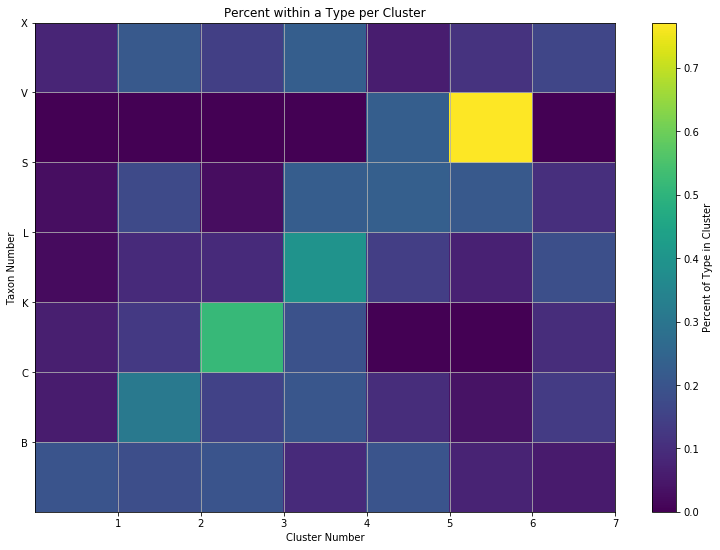

In [28]:
ax = pl.figure(figsize = (13, 9))
pl.pcolor(taxonArr, vmin = 0, vmax = np.max(taxonArr))
pl.title("Percent within a Type per Cluster")
pl.colorbar(label = "Percent of Type in Cluster")
pl.xlabel("Cluster Number")
pl.xticks(np.arange(1, numClusters + 1))
pl.ylabel("Taxon Number")
pl.yticks(np.arange(1, numClusters + 1), labels = np.unique(taxonomy.spec_B))
pl.grid();